In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm


In [ ]:
# Define the data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Colab Notebooks'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                             shuffle=True, num_workers=4)
               for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


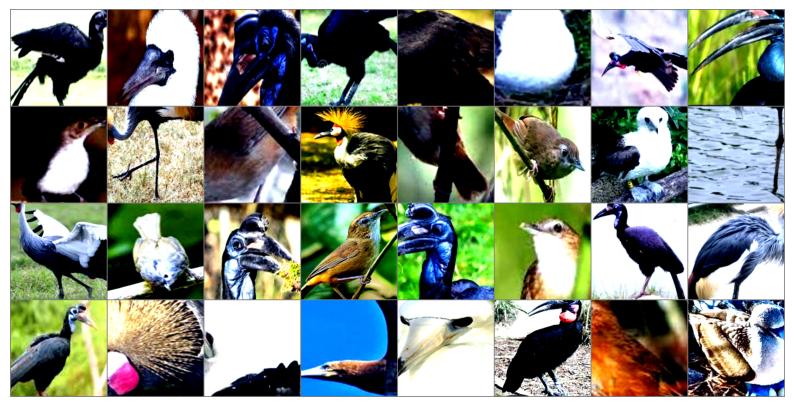

In [ ]:

import torchvision

def imshow(inputs, title=None):
    # Unnormalize
    inputs = inputs / 2 + 0.5
    npimg = inputs.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
inputs, _ = next(iter(dataloaders['train']))

# Make a grid from the batch
out = torchvision.utils.make_grid(inputs)

# Create a larger figure
plt.figure(figsize=(10, 10))

# Display the images
imshow(out)
plt.show()


In [ ]:
model_ft = models.resnet18(pretrained=True)

# Freeze the layers except the last layer
for param in model_ft.parameters():
    param.requires_grad = False

# Modify the final layer to match the number of classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.0MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()

# Only parameters of the final layer are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save loss and accuracy for plotting
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, train_loss, val_loss, train_acc, val_acc


In [ ]:
model_ft, train_loss, val_loss, train_acc, val_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)


Epoch 0/9
----------


100%|██████████| 21/21 [01:21<00:00,  3.88s/it]


train Loss: 1.3175 Acc: 0.4307


100%|██████████| 1/1 [00:07<00:00,  8.00s/it]


valid Loss: 0.7566 Acc: 0.7000

Epoch 1/9
----------


100%|██████████| 21/21 [01:13<00:00,  3.49s/it]


train Loss: 0.6616 Acc: 0.8265


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


valid Loss: 0.2629 Acc: 1.0000

Epoch 2/9
----------


100%|██████████| 21/21 [01:14<00:00,  3.56s/it]


train Loss: 0.4249 Acc: 0.9056


100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


valid Loss: 0.2061 Acc: 1.0000

Epoch 3/9
----------


100%|██████████| 21/21 [01:13<00:00,  3.52s/it]


train Loss: 0.3554 Acc: 0.9224


100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


valid Loss: 0.1222 Acc: 1.0000

Epoch 4/9
----------


100%|██████████| 21/21 [01:19<00:00,  3.77s/it]


train Loss: 0.3163 Acc: 0.9254


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


valid Loss: 0.1088 Acc: 1.0000

Epoch 5/9
----------


100%|██████████| 21/21 [01:16<00:00,  3.62s/it]


train Loss: 0.3179 Acc: 0.9011


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


valid Loss: 0.0940 Acc: 1.0000

Epoch 6/9
----------


100%|██████████| 21/21 [01:15<00:00,  3.58s/it]


train Loss: 0.2717 Acc: 0.9315


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


valid Loss: 0.0552 Acc: 1.0000

Epoch 7/9
----------


100%|██████████| 21/21 [01:15<00:00,  3.58s/it]


train Loss: 0.2841 Acc: 0.9163


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


valid Loss: 0.0557 Acc: 1.0000

Epoch 8/9
----------


100%|██████████| 21/21 [01:14<00:00,  3.56s/it]


train Loss: 0.2689 Acc: 0.9269


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


valid Loss: 0.0620 Acc: 1.0000

Epoch 9/9
----------


100%|██████████| 21/21 [01:15<00:00,  3.60s/it]


train Loss: 0.2691 Acc: 0.9300


100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

valid Loss: 0.0641 Acc: 1.0000

Training complete in 13m 10s


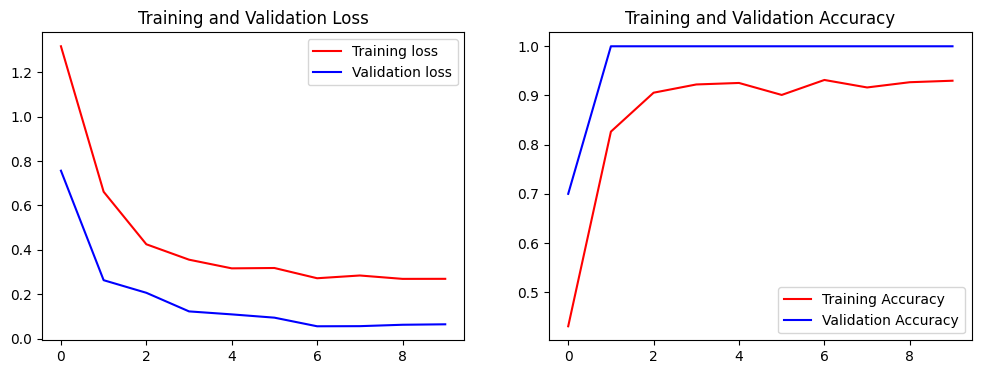

In [ ]:
# Plot loss and accuracy
epochs = range(10)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
# Define the test data transforms
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dir = '/content/drive/MyDrive/Colab Notebooks/test'
test_dataset = datasets.ImageFolder(test_dir, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
test_size = len(test_dataset)


In [ ]:
def test_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / test_size
    test_acc = running_corrects.double() / test_size

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}') #validation, training and test dataset percentage practical

    return test_loss, test_acc


In [ ]:
test_loss, test_acc = test_model(model_ft, test_loader, criterion)


100%|██████████| 1/1 [00:08<00:00,  8.42s/it]

Test Loss: 0.0812 Acc: 1.0000


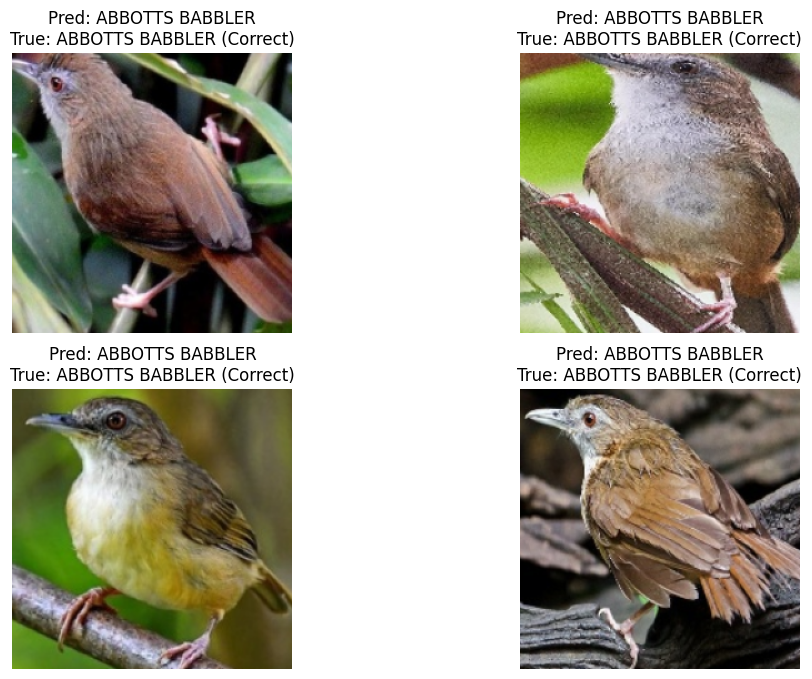

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide the axis

def visualize_predictions(model, dataloader, class_names, num_images=4):
    """Visualize predictions from the model on a few images."""
    model.eval()  # Set model to evaluation mode

    # Get a batch of test data
    inputs, labels = next(iter(dataloader))
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Predict
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Display the images along with predictions
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        ax = plt.subplot(2, 2, i + 1)
        imshow(inputs.cpu().data[i])
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        title = f'Pred: {pred_label}\nTrue: {true_label}'
        if pred_label == true_label:
            title = title + ' (Correct)'
        else:
            title = title + ' (Incorrect)'
        ax.set_title(title)
    plt.show()

# Example usage
visualize_predictions(model_ft, test_loader, class_names, num_images=4)


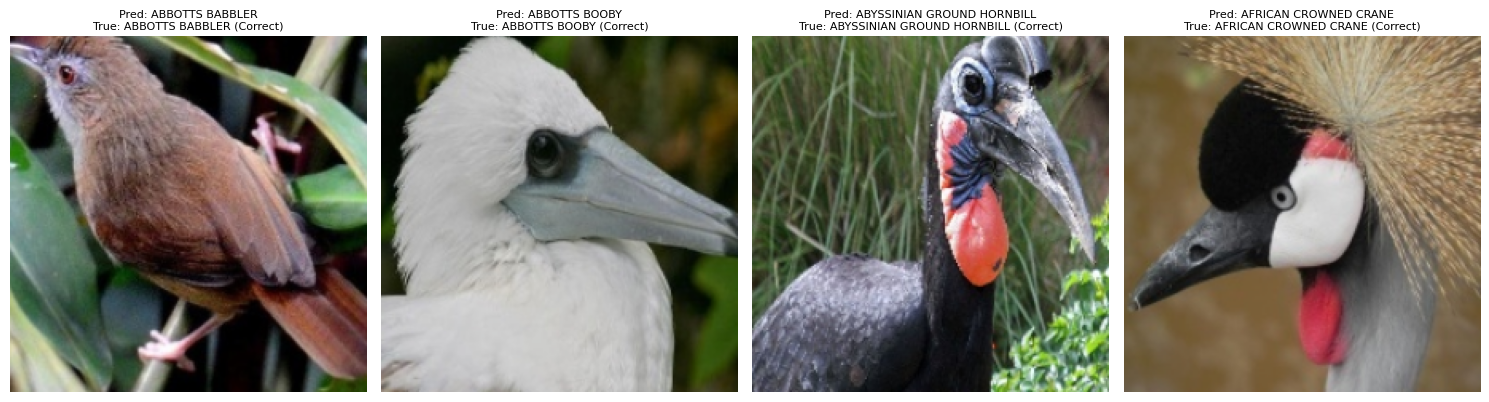

In [ ]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=10)
    plt.axis('off')  # Hide the axis

def show_images_from_different_classes(model, dataloader, class_names, num_images=8):
    """Show images from different classes with predictions and true labels."""
    model.eval()  # Set model to evaluation mode

    # Initialize class trackers
    class_images = {cls: None for cls in class_names}

    # Process each batch in the dataloader
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Predict
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Store images from different classes
            for img, label, pred in zip(inputs.cpu(), labels.cpu(), preds.cpu()):
                label_name = class_names[label]
                if class_images[label_name] is None:
                    class_images[label_name] = (img, label_name, class_names[pred])
                # Stop once we have enough images
                if all(v is not None for v in class_images.values()):
                    break
            if all(v is not None for v in class_images.values()):
                break

    # Filter out classes where no images were found
    class_images = {k: v for k, v in class_images.items() if v is not None}

    # Display the images
    plt.figure(figsize=(15, 10))
    num_classes = len(class_images)
    cols = 4  # Number of columns in the grid
    rows = (num_classes + cols - 1) // cols  # Calculate rows needed

    for i, (img, true_label, pred_label) in enumerate(class_images.values()):
        if i >= num_images:
            break
        ax = plt.subplot(rows, cols, i + 1)
        imshow(img)
        title = f'Pred: {pred_label}\nTrue: {true_label}'
        if pred_label == true_label:
            title = title + ' (Correct)'
        else:
            title = title + ' (Incorrect)'
        ax.set_title(title, fontsize=8, pad=5)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
show_images_from_different_classes(model_ft, test_loader, class_names, num_images=8)


In [ ]:
# from google.colab import files
# torch.save(model_ft.state_dict(), 'birds_resnet18.pth')
# files.download('birds_resnet18.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Define image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Attempt to load the image
img = cv2.imread(r'burung5.jpg')

# Check if the image was loaded successfully
if img is None:
    raise FileNotFoundError("The image file 'burung5.jpg' could not be loaded. Check the file path.")

# Convert the OpenCV image (NumPy array) to a PIL image
image = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Apply the transformations
image = preprocess(image)

# Unsqueeze to add a batch dimension
image = image.unsqueeze(0)  # Shape: [1, 3, 224, 224]

# Define the specific layers to visualize based on your summary
conv_layers = [
    model.conv1,             # First convolutional layer
    model.layer1[0].conv1,   # Conv layer from first residual block
    model.layer1[0].conv2,   # Conv layer from first residual block
    model.layer2[0].conv1,   # Conv layer from second residual block
    model.layer3[0].conv1,   # Conv layer from third residual block
    model.layer4[0].conv1    # Conv layer from fourth residual block
]

# Function to pass the image through the layers and collect the outputs
def get_resnet_outputs(model, image, conv_layers):
    outputs = []
    x = image
    for layer in conv_layers:
        x = layer(x)
        outputs.append(x)
    return outputs

# Move the image and model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
image = image.to(device)

# Get the outputs from the defined layers
outputs = get_resnet_outputs(model, image, conv_layers)

# Visualize the feature maps
for num_layer, output in enumerate(outputs):
    plt.figure(figsize=(30, 30))
    # For ResNet, outputs can have multiple sub-layers, so we need to handle them
    if len(output.shape) == 4:  # [batch_size, num_filters, height, width]
        layer_viz = output[0, :, :, :]  # Take the first image in the batch
        print(f"Layer {num_layer} output shape: {layer_viz.shape}")

        for i in range(min(layer_viz.shape[0], 64)):  # Show up to 64 filters
            plt.subplot(8, 8, i + 1)
            plt.imshow(layer_viz[i].cpu().detach().numpy(), cmap='gray')
            plt.axis("off")

        print(f"Saving layer {num_layer} feature maps...")
        plt.savefig(f"./layer_{num_layer}_feature_maps.png")
        plt.close()


Layer 0 output shape: torch.Size([64, 112, 112])
Saving layer 0 feature maps...
Layer 1 output shape: torch.Size([64, 112, 112])
Saving layer 1 feature maps...
Layer 2 output shape: torch.Size([64, 112, 112])
Saving layer 2 feature maps...
Layer 3 output shape: torch.Size([128, 56, 56])
Saving layer 3 feature maps...
Layer 4 output shape: torch.Size([256, 28, 28])
Saving layer 4 feature maps...
Layer 5 output shape: torch.Size([512, 14, 14])
Saving layer 5 feature maps...
